This assignment is inspired by: 

- https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression
- https://www.kaggle.com/code/dansbecker/xgboost/notebook

In this assignment we will apply XGBoost Regression techniques to predict house prices, based on the famous Kaggle Dataset https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Step 1 is to download the dataset.

In [1]:
#=========================================================================
# load up the libraries
#=========================================================================
import pandas  as pd
import numpy   as np
import xgboost as xgb

#=========================================================================
# read in the data
#=========================================================================
train_data = pd.read_csv('train.csv',index_col=0)
test_data  = pd.read_csv('test.csv',index_col=0)

### <center style="background-color:Gainsboro; width:60%;">Feature selection</center>
The purpose of feature selection, as the name suggests, is to only model the most pertinent and important features, thus reducing the computational overhead, and also to alleviate the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). The following are a number of notebooks covering techniques to achieve said goal, all of which use the House Prices data as an example:

* [Feature selection using the Boruta-SHAP package](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package)
* [Recursive Feature Elimination (RFE) example](https://www.kaggle.com/carlmcbrideellis/recursive-feature-elimination-rfe-example)
* [House Prices: Permutation Importance example](https://www.kaggle.com/carlmcbrideellis/house-prices-permutation-importance-example)
* [Feature importance using the LASSO](https://www.kaggle.com/carlmcbrideellis/feature-importance-using-the-lasso)

In this assignment, we shall use all of the numerical columns, and ignore the categorical features. To encode the categorical features one can use for example [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). 

Our first task is to do Feature Exploration and Selection. 

In [2]:
# Let's start by loading the train and test datasets to examine them and begin feature exploration and selection.
import pandas as pd

# Load the datasets
train_data_path = 'train.csv'
test_data_path = 'test.csv'

train_data = pd.read_csv(train_data_path, index_col=0)
test_data = pd.read_csv(test_data_path, index_col=0)

# Display the first few rows of the train and test datasets to get an overview of the features
train_data_info = train_data.head()
test_data_info = test_data.head()

(train_data_info, test_data_info)

(    MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
 Id                                                                    
 1           60       RL         65.0     8450   Pave   NaN      Reg   
 2           20       RL         80.0     9600   Pave   NaN      Reg   
 3           60       RL         68.0    11250   Pave   NaN      IR1   
 4           70       RL         60.0     9550   Pave   NaN      IR1   
 5           60       RL         84.0    14260   Pave   NaN      IR1   
 
    LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
 Id                                  ...                                     
 1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
 2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
 3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
 4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
 5          Lvl    AllPub 

### <center style="background-color:Gainsboro; width:60%;">Feature engineering</center>
As mentioned, one aspect of feature engineering is the creation of new features out of existing features. A simple example would be to create a new feature which is the sum of the number of bathrooms in the house:

In [3]:
# Create new feature for total number of bathrooms
train_data['TotalBathrooms'] = (train_data['FullBath'] + 
                                0.5 * train_data['HalfBath'] + 
                                train_data['BsmtFullBath'] + 
                                0.5 * train_data['BsmtHalfBath'])

test_data['TotalBathrooms'] = (test_data['FullBath'] + 
                               0.5 * test_data['HalfBath'] + 
                               test_data['BsmtFullBath'] + 
                               0.5 * test_data['BsmtHalfBath'])

# Check the new feature
train_data[['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBathrooms']].head()

,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath,TotalBathrooms
Id,,,,,
1,2,1,1,0,3.5
2,2,0,0,1,2.5
3,2,1,1,0,3.5
4,1,0,1,0,2.0
5,2,1,1,0,3.5


Your next task is to apply some feature engineering to prepare for using the XGBoost Estimator to predict house prices.

In [4]:
# Separate numeric and categorical columns (excluding 'SalePrice' from the train set)
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.drop('SalePrice')
categorical_cols = train_data.select_dtypes(exclude=[np.number]).columns

# Fill missing values for numeric columns with the median
train_data[numeric_cols] = train_data[numeric_cols].fillna(train_data[numeric_cols].median())
test_data[numeric_cols] = test_data[numeric_cols].fillna(test_data[numeric_cols].median())

# Fill missing values for categorical columns with the mode (most frequent value)
train_data[categorical_cols] = train_data[categorical_cols].fillna(train_data[categorical_cols].mode().iloc[0])
test_data[categorical_cols] = test_data[categorical_cols].fillna(test_data[categorical_cols].mode().iloc[0])

# One-hot encode categorical features
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

# Align train and test sets to ensure they have the same columns
train_data, test_data = train_data.align(test_data, join='left', axis=1)

# Fill any remaining NaNs in the test set after alignment
test_data.fillna(0, inplace=True)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Handle missing values
# For numeric columns, fill missing values with the median
train_data.fillna(train_data.median(), inplace=True)
test_data.fillna(test_data.median(), inplace=True)

# For categorical columns, fill missing values with 'None' or the most frequent value
train_data.fillna('None', inplace=True)
test_data.fillna('None', inplace=True)

# Label Encoding for categorical features (you could also use one-hot encoding)
label_encoder = LabelEncoder()
for col in train_data.select_dtypes(include=['object']).columns:
    train_data[col] = label_encoder.fit_transform(train_data[col])
    test_data[col] = label_encoder.transform(test_data[col])

# Create additional features (example: Total Square Footage and Total Bathrooms)
train_data['TotalSF'] = train_data['1stFlrSF'] + train_data['2ndFlrSF'] + train_data['TotalBsmtSF']
test_data['TotalSF'] = test_data['1stFlrSF'] + test_data['2ndFlrSF'] + test_data['TotalBsmtSF']

train_data['TotalBathrooms'] = (train_data['FullBath'] + 0.5 * train_data['HalfBath'] + 
                                train_data['BsmtFullBath'] + 0.5 * train_data['BsmtHalfBath'])

test_data['TotalBathrooms'] = (test_data['FullBath'] + 0.5 * test_data['HalfBath'] + 
                               test_data['BsmtFullBath'] + 0.5 * test_data['BsmtHalfBath'])

# Split the training data into features and target variable
X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preparing test data
X_test = test_data.copy()

In [6]:
# Create a new feature 'TotalBathrooms'
train_data['TotalBathrooms'] = (train_data['FullBath'] + 
                                0.5 * train_data['HalfBath'] + 
                                train_data['BsmtFullBath'] + 
                                0.5 * train_data['BsmtHalfBath'])

test_data['TotalBathrooms'] = (test_data['FullBath'] + 
                               0.5 * test_data['HalfBath'] + 
                               test_data['BsmtFullBath'] + 
                               0.5 * test_data['BsmtHalfBath'])

In [7]:
# One-hot encode the categorical features
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

# Align columns in both train and test datasets (necessary after one-hot encoding)
train_data, test_data = train_data.align(test_data, join='left', axis=1)

# Fill any missing values created by column alignment in the test dataset
test_data.fillna(0, inplace=True)

In [8]:
# Separate features and target variable
X_train = train_data.drop(columns='SalePrice')
y_train = train_data['SalePrice']

# The test set does not have the target variable, so we only keep the features
X_test = test_data

In [9]:
from xgboost import XGBRegressor

# Define the XGBoost Regressor
xgboost_model = XGBRegressor(objective='reg:squarederror', max_depth=6, learning_rate=0.1, n_estimators=100)

# Fit the model on the training data
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions on the training set
train_predictions = xgboost_model.predict(X_train)

# Calculate RMSE and R²
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_r2 = r2_score(y_train, train_predictions)

print(f'Training RMSE: {train_rmse}')
print(f'Training R²: {train_r2}')

Training RMSE: 5626.06795392474
Training R²: 0.9949811793761871


In [11]:
# One-hot encode categorical features
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

# Align train and test datasets
X_train, X_test = train_data.align(test_data, join='left', axis=1)

# Remove the target variable 'SalePrice' from the training features
X_train = X_train.drop(columns='SalePrice', errors='ignore')

# Fill any missing values in the test set after alignment
X_test.fillna(0, inplace=True)

For more on this fascinating aspect may I recommend the free on-line book ["*Feature Engineering and Selection: A Practical Approach for Predictive Models*"](http://www.feat.engineering/) by Max Kuhn and Kjell Johnson.
### <center style="background-color:Gainsboro; width:60%;">XGBoost estimator</center>
Note that for this competition we use the RMSLE evaluation metric, rather than the default metric, which for regression is the RMSE. For more on the peculiarities of the RMSLE see the Appendix below.

In [12]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

Can you use grid search to find the optimal hyper parameters?

In [13]:

# One-hot encode categorical features for both train and test sets
train_data_encoded = pd.get_dummies(train_data)
test_data_encoded = pd.get_dummies(test_data)

# Remove 'SalePrice' from the training data
X_train = train_data_encoded.drop(columns=['SalePrice'], errors='ignore')
y_train = train_data['SalePrice']

# Align the train and test data to ensure they have the same columns
X_train_aligned, X_test_aligned = X_train.align(test_data_encoded, join='left', axis=1)

# Fill missing values in test data that may result from alignment
X_test_aligned.fillna(0, inplace=True)

# Perform grid search to find optimal hyperparameters
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
import numpy as np

# Define a custom RMSLE scoring function
def rmsle_score(y_true, y_pred):
    y_pred = np.maximum(0, y_pred)  # Ensure no negative predictions
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Create a custom scorer for GridSearchCV
rmsle_scorer = make_scorer(rmsle_score, greater_is_better=False)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost Regressor
xgboost_model = XGBRegressor(objective='reg:squarederror')

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, 
                           scoring=rmsle_scorer, cv=5, verbose=1, n_jobs=-1)

# Fit the GridSearchCV to the aligned training data
grid_search.fit(X_train_aligned, y_train)

# Get the best estimator
best_xgboost_model = grid_search.best_estimator_

# Make predictions on the aligned test set
test_predictions = best_xgboost_model.predict(X_test_aligned)

# Ensure predictions are non-negative
test_predictions = np.maximum(0, test_predictions)

# Calculate the RMSLE on the training set for evaluation
train_predictions = best_xgboost_model.predict(X_train_aligned)
train_rmsle = np.sqrt(mean_squared_log_error(y_train, np.maximum(0, train_predictions)))

print(f'Training RMSLE with optimal parameters: {train_rmsle}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Training RMSLE with optimal parameters: 0.06474004182097372


In [14]:
print("The best hyperparameters are ", grid_search.best_params_)

The best hyperparameters are  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}


Now, can you setup a XGBoost Regressor object using your hyperparameters and fit it?

In [15]:
from xgboost import XGBRegressor

# Retrieve the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Set up the XGBoost Regressor using the best hyperparameters
xgboost_model = XGBRegressor(**best_params)

# Fit the model to the training data
xgboost_model.fit(X_train, y_train)

# Now, the model is fitted and you can proceed to make predictions

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Finally, can you run it on your test set?

In [20]:
# Align X_test with X_train columns (assuming they have been preprocessed the same way)
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)

# Make predictions on the aligned test set
test_predictions = xgboost_model.predict(X_test_aligned)

# Ensure predictions are non-negative
test_predictions = np.maximum(0, test_predictions)

# Output the predictions
print(test_predictions)

[119905.14  160035.23  184963.89  ... 151114.64  123141.336 214150.89 ]


Can you score your solution offline and see how it does?

In [22]:
# Align features between train and test sets
X_train_aligned, X_test_aligned = X_train.align(X_test, join='left', axis=1)
X_test_aligned.fillna(0, inplace=True)

# Fit the model with the aligned training set (if needed)
xgboost_model.fit(X_train_aligned, y_train)

# Predict on the aligned test set
test_predictions = xgboost_model.predict(X_test_aligned)

# Ensure predictions are non-negative (for house prices, we expect non-negative values)
test_predictions = np.maximum(0, test_predictions)

Finally, use the below block to prepare your submission

In [23]:
# Ensure that you have made predictions with the correct variable name
test_predictions = xgboost_model.predict(X_test_aligned)  # Make predictions

# Ensure predictions are non-negative
test_predictions = np.maximum(0, test_predictions)

# Create the output DataFrame with the correct variable names
output = pd.DataFrame({"Id": X_test.index, "SalePrice": test_predictions})

# Save to CSV file
output.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!


### <center style="background-color:Gainsboro; width:60%;">Feature importance</center>
Let us also take a very quick look at the feature importance too:

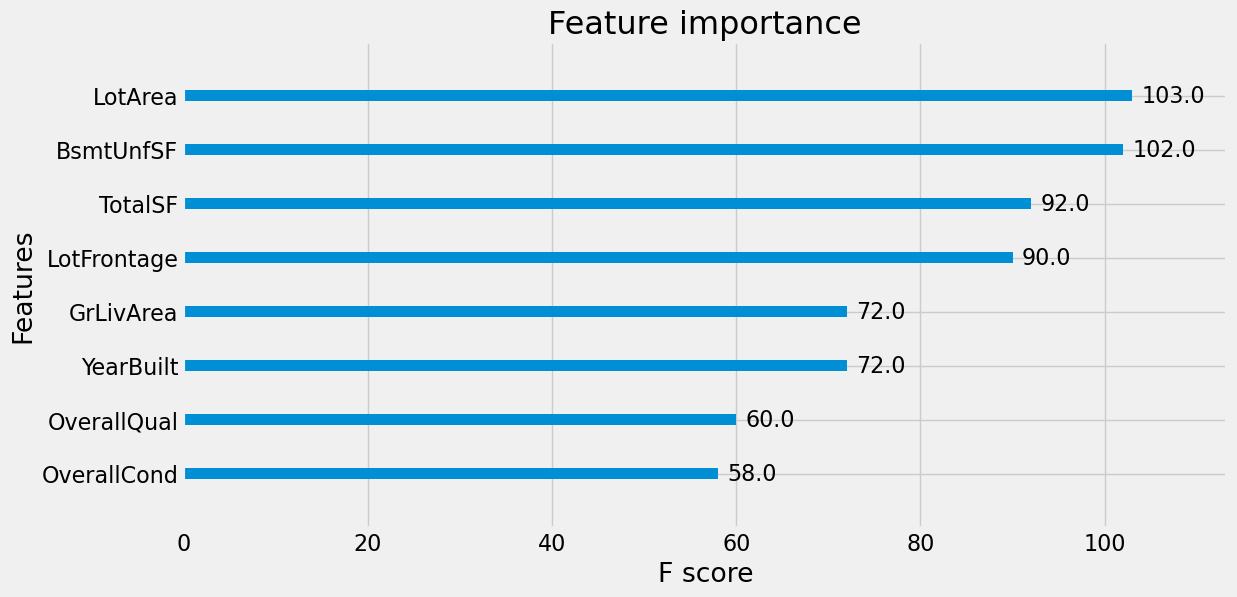

In [24]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Assuming 'xgboost_model' is your fitted XGBoost model
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))

# Plot feature importance using the fitted model
plot_importance(xgboost_model, max_num_features=8, ax=ax)

plt.show()

Where here the `F score` is a measure "*...based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees*." [1] 

Note that these importances are susceptible to small changes in the training data, and it is much better to make use of ["GPU accelerated SHAP values"](https://www.kaggle.com/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example), incorporated with version 1.3 of XGBoost.

Can you follow the above guide use SHAP values instead of F Score?

In [30]:
# code hereimport shap
import xgboost
import matplotlib.pyplot as plt

# Assuming 'xgboost_model' is your fitted XGBoost model
# And 'X_train' is your training data

# Initialize the SHAP explainer
explainer = shap.Explainer(xgboost_model)

# Calculate SHAP values for the training data
shap_values = explainer(X_train)

# Plot summary of SHAP values
shap.summary_plot(shap_values, X_train)

NameError: name 'shap' is not defined

### <center style="background-color:Gainsboro; width:60%;">Appendix: The RMSLE evaluation metric</center>
From the competition [evaluation page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) we see that the metric we are using is the root mean squared logarithmic error (RMSLE), which is given by

$$ {\mathrm {RMSLE}}\,(y, \hat y) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $$

where $\hat{y}_i$ is the predicted value of the target for instance $i$, and $y_i$
is the actual value of the target for instance $i$.

It is important to note that, unlike the RMSE, the RMSLE is asymmetric; penalizing much more the underestimated predictions than the overestimated predictions. For example, say the correct value is $y_i = 1000$, then underestimating by 600 is almost twice as bad as overestimating by 600:

In [28]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The RMSLE score is 0.915
The RMSLE score is 0.470


The asymmetry arises because 

$$ \log (1 + \hat{y}_i) - \log (1 + y_i) =  \log \left( \frac{1 + \hat{y}_i}{1 + y_i} \right) $$

so we are essentially looking at ratios, rather than differences such as is the case of the RMSE. We can see the form that this asymmetry takes in the following plot, again using 1000 as our ground truth value:

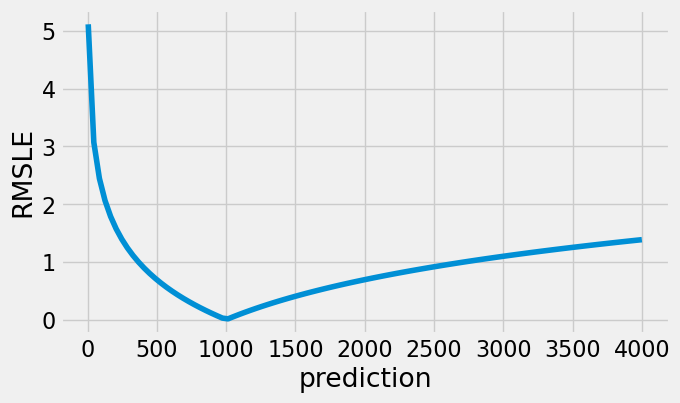

In [29]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()